# 🗂️ Data Loading and Preprocessing:

In [1]:
import sys
sys.path.append('./src')
from utils import preprocess_dataset, plot_dataset
import zipfile
import os
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
zip_file_path = './data/train_df.csv.zip'
path_raw_data = './data/train_df.csv'
output_folder = './data'

# Check if the file doesn't exist
if not os.path.exists(path_raw_data):
    # Open the zip file in read mode
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all files in the zip file to the output folder
        zip_ref.extractall(output_folder)

In [4]:
dataset = preprocess_dataset(path_raw_data)
dataset

Using custom data configuration default-4d2a81cda03a0271


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Parameter 'function'=<function Dataset.class_encode_column.<locals>.stringify_column at 0x7f8b024cf820> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4d2a81cda03a0271/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


Stringifying the column:   0%|          | 0/28 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/28 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Words Per Essay'],
        num_rows: 24615
    })
    test: Dataset({
        features: ['text', 'label', 'Words Per Essay'],
        num_rows: 2735
    })
})

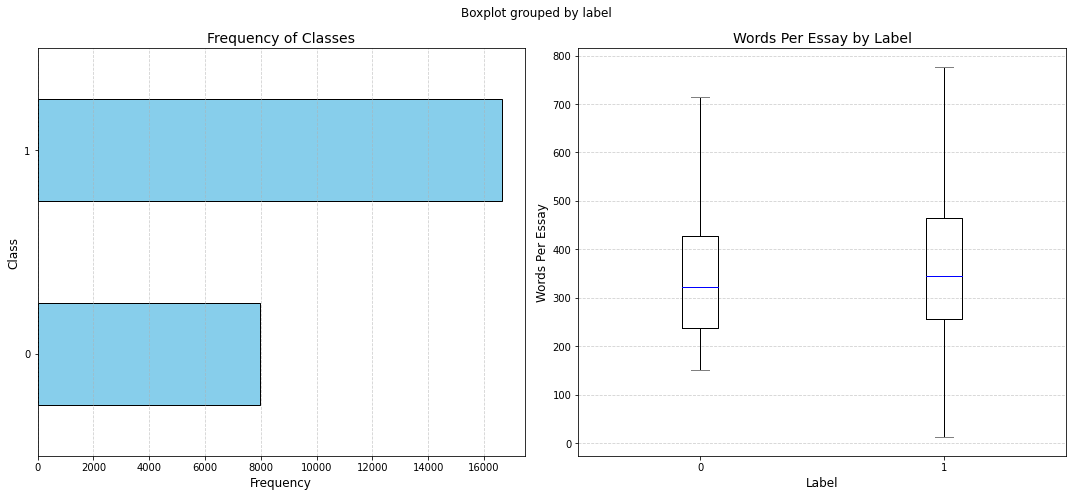

In [5]:
plot_dataset(dataset)

# 🔪 Split Text to Tokens:

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

dataset.reset_format()

def tokenize(batch):
    return tokenizer(batch["text"], padding='max_length', truncation=True, max_length=768)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=32)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/770 [00:00<?, ?ba/s]

  0%|          | 0/86 [00:00<?, ?ba/s]

# 💻 Baseline Classifier Using Pretrained Model Embeddings

In this section:

1. **Pretrained Model:** Use a pretrained model to process input data.
2. **Extract Hidden States:** Obtain hidden states from the model, serving as input features.
3. **Logistic Regression:** Fit these features to a logistic regression model for baseline classification.
4. **Visualization:** Display results to evaluate baseline performance.

This approach provides a foundation for comparing the impact of further model fine-tuning.

In [7]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained("microsoft/deberta-v3-base").to(device)

# Our model expects torch tensors as input
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
from visualization_and_metrics import extract_hidden_states
from functools import partial

dataset_hidden = dataset_encoded.map(partial(extract_hidden_states, tokenizer=tokenizer, device=device, model=model),
                                     batched=True, batch_size=32)

dataset_hidden

  0%|          | 0/770 [00:00<?, ?ba/s]

  0%|          | 0/86 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Words Per Essay', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 24615
    })
    test: Dataset({
        features: ['text', 'label', 'Words Per Essay', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2735
    })
})

### Visualizing the embeddings with UMAP:

**UMAP (Uniform Manifold Approximation and Projection)** is a modern technique for dimensionality reduction, particularly effective for visualizing textual data. Key features include:

- **Manifold Learning**: Assumes data lies on a lower-dimensional manifold in a higher-dimensional space.
- **Local Structure Preservation**: Maintains the relationships and clusters present in the original high-dimensional space.
- **Efficiency**: Suitable for large datasets, offering speed and meaningful insights.
- **Application**: Transforms high-dimensional text embeddings (like Word2Vec) into a 2D or 3D space, highlighting patterns, clusters, and trends.

UMAP's ability to reveal underlying structures makes it invaluable for intuitive exploration of complex textual datasets.


In [9]:
import numpy as np

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["test"]["label"])

X_train.shape, X_valid.shape

((24615, 768), (2735, 768))

The below cell might take some time:

In [10]:
from utils import generate_embeddings

df_emb = generate_embeddings(X_train, y_train)
df_emb.head()

,X,Y,label
0,10.368858,1.158969,1
1,10.268909,2.910129,1
2,2.284895,0.390898,1
3,-1.204461,2.864578,1
4,-1.309554,1.688039,1


# UMAP Embeddings Visualization

The visualization below shows the UMAP embeddings of the dataset, providing a 2D spatial representation of our high-dimensional essay data. UMAP has projected these embeddings into a space where similar data points are closer together, thus allowing us to observe the clustering patterns of AI-generated and human-authored essays.

The embeddings produced by a non-finetuned model exhibit a high degree of similarity between `AI-generated` and `human-authored` essays. This indicates that, without fine-tuning, the model **does not distinctly differentiate between the two types of essays in its embeddings.**

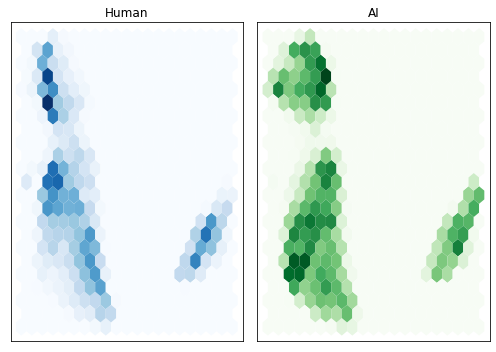

In [11]:
from visualization_and_metrics import plot_emb

plot_emb(df_emb)

### Training a simple baseline classifier:

#### Evaluating Model Performance with Logistic Regression

In the following code cells, we will validate our observations from the UMAP plot, which suggested that the embeddings from the non-finetuned model are insufficient for effective classification. We will do this by:

1. **Using Model Embeddings**: Employing the embeddings from the non-finetuned model as features.
2. **Training a Logistic Regression Model**: Fitting these features to a logistic regression model.
3. **Assessment**: Assessing the model's performance to confirm if the non-finetuned embeddings are indeed inadequate for reliable classification of AI-generated versus human-authored essays.


In [12]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.8716636197440585

              precision    recall  f1-score   support

           0       0.85      0.73      0.79       887
           1       0.88      0.94      0.91      1848

    accuracy                           0.87      2735
   macro avg       0.87      0.84      0.85      2735
weighted avg       0.87      0.87      0.87      2735



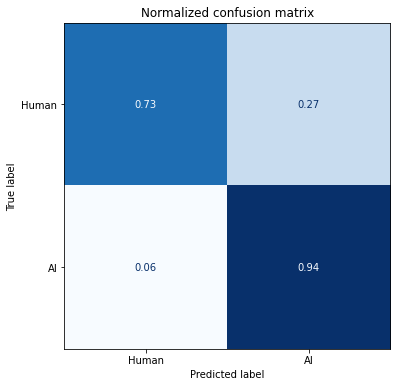

In [13]:
from sklearn.metrics import classification_report, roc_auc_score
from visualization_and_metrics import plot_confusion_matrix

labels = ["Human", "AI"]
y_preds = lr_clf.predict(X_valid)
y_preds_proba = lr_clf.predict_proba(X_valid)[:,-1]

print(classification_report(y_valid, y_preds))
plot_confusion_matrix(y_preds, y_valid, labels)



While the model performs well in identifying AI-generated essays, its ability to recognize human-authored essays is comparatively lower, especially in terms of recall. This suggests a need for model refinement or additional features to improve differentiation capabilities.

# 📈 Improving the Classifier with Advanced Pretraining

In this section, we aim to enhance our classifier's performance by leveraging a `transformer model`. Unlike the original version, this transformer has undergone **an additional pretraining phase**. This pretraining involved processing approximately `500,000 pairs of texts`, with an equal mix of human-generated and AI-generated content, resulting in around 1 million rows of data. Notably, the dataset employed for this training encompasses a **broad range of text types** and is not limited to essays. This comprehensive approach is crucial for pretraining the transformer to discern AI-generated content in general contexts, a foundational step before `fine-tuning` it for our specific objective.

## Objective
Our primary goal is to fine-tune this transformer model to **detect whether essays submitted by students are generated by AI**. 

## Methodology
In the upcoming code section, we will load the `state dictionary` of this pretrained model. This step is a precursor to fine-tuning the model on a more narrowly focused dataset, consisting solely of essays. 

## Reproducing Pretraining
For those interested in replicating the pretraining process:
- The necessary input files are available for download. Refer to the link provided at the bottom of the README file.
- Once downloaded, place these files in the `data` folder.
- Execute the `pretrain_model.py` script. This will initiate the pretraining process.
- The pretraining outputs, including the weights, will be saved in the `outputs` folder, named `weights_pre_trained_ep0`.

This advanced pretraining strategy is expected to significantly bolster the model's ability to differentiate between human and AI-generated texts, particularly in the context of student essays.


In [14]:
import json

# Load the configuration file
with open('config.json') as config_file:
    config_model = json.load(config_file)

seed = config_model['seed']
learning_rate = config_model['learning_rate']
max_len = config_model['max_len']
batch_size = config_model['batch_size']
num_epoch = config_model['num_epoch']
model_path = config_model['model_path']
out_dir = config_model['out_dir']
pretrained_model_path = config_model['pretrained_model_path']

In [15]:
from training import get_dataloader, get_model_for_training
from transformers import get_linear_schedule_with_warmup
from utils import seed_everything
from torch import optim

seed_everything(seed)

train_generator = get_dataloader(dataset_encoded, tokenizer, max_len, batch_size)

model = get_model_for_training(model_path, pretrained_model_path)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_train_steps = int(len(dataset_encoded['train'])/(batch_size*3)*num_epoch)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

In [16]:
from training import launch_training

launch_training(model, num_epoch, train_generator, device, optimizer, scheduler, out_dir)

train   1.0    0.0    |     0.171     |epoch: 0, train_loss: 0.1708646332027465
1043.344719171524


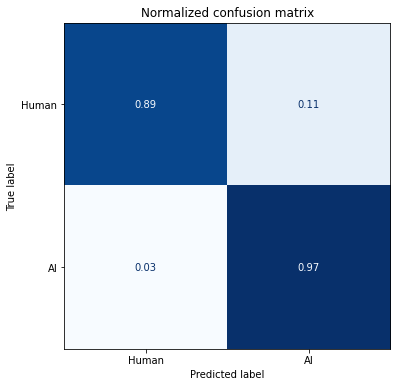

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       887
           1       0.95      0.97      0.96      1848

    accuracy                           0.95      2735
   macro avg       0.95      0.93      0.94      2735
weighted avg       0.95      0.95      0.95      2735

roc auc score: 0.9863169055671874


In [17]:
from training import evaluate_model

test_generator = get_dataloader(dataset_encoded, tokenizer, max_len, batch_size, split='test')

# Evaluate model
pred_labels, pred_prob = evaluate_model(model, test_generator, batch_size)

# Plot results:
label_list = dataset_encoded['test']['label'].tolist()
plot_confusion_matrix(pred_labels, label_list, labels)
print(classification_report(label_list, pred_labels))
print("roc auc score:", roc_auc_score(label_list, pred_prob))

#### Visualizing hidden states after the model has been finetuned:

In [18]:
from visualization_and_metrics import extract_hidden_states_custom_model

# Our model expects torch tensors as input
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

dataset_hidden = dataset_encoded.map(partial(extract_hidden_states_custom_model, tokenizer=tokenizer, device=device, model=model),
                                     batched=True, batch_size=batch_size)


dataset_hidden

  0%|          | 0/770 [00:00<?, ?ba/s]

  0%|          | 0/86 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Words Per Essay', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 24615
    })
    test: Dataset({
        features: ['text', 'label', 'Words Per Essay', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2735
    })
})

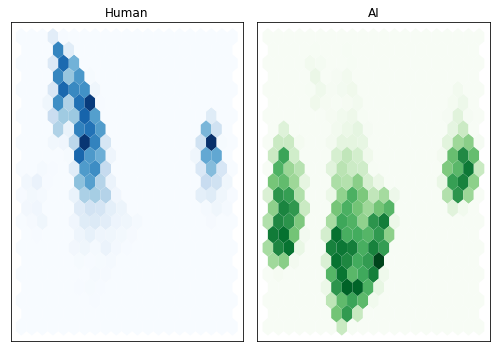

In [19]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])

df_emb = generate_embeddings(X_train, y_train)
plot_emb(df_emb)

## Observations:
- **Clustering**: There is a clear clustering of data points, with one cluster representing human-authored essays (left) and another representing AI-generated essays (right). This suggests a good separation capability of the model's learned embeddings.
- **Overlap**: While there is distinct clustering, there's also some overlap or close proximity between a few data points from both categories. This indicates areas where the model may have difficulty distinguishing between AI and human text.
- **Density**: The AI-generated essays seem to form denser clusters compared to the human-authored ones, which could imply that AI essays have more consistent embedding patterns, whereas human writing shows greater variability.

## Implications for Model Training:
- **Separation Quality**: The visible separation between clusters is promising for the classification task, as it implies that the model can differentiate between AI-generated and human text to a certain extent.
- **Potential Challenges**: The regions of overlap may require further attention during model training to improve the classifier's ability to accurately distinguish between the two types of essays.

## Next Steps:
- **Fine-Tuning**: Given the clear, yet imperfect, separation, further fine-tuning of the model may enhance its discriminative power.
- **Feature Engineering**: Exploring additional features or embedding techniques might also help in reducing the overlap between the two types of essays.
- **Error Analysis**: Investigating the points of overlap could provide insights into specific cases where the model is currently confused, guiding potential improvements.

By analyzing these embeddings, we can better understand the feature space that our model is working with and how well it might perform in distinguishing between human and AI-generated texts.